In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import numpy as np
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
from sklearn import preprocessing, decomposition
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix
import itertools
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline
from yellowbrick.text import FreqDistVisualizer
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

In [ ]:
# Load your data
data = pd.read_csv('main_dataframe.csv')


data.rename(columns={'Content': 'content', 'BIRADS Score': 'label'}, inplace=True)

# Tokenization parameters
MAX_NB_WORDS = 5000  # Maximum number of words in tokenizer
MAX_SEQUENCE_LENGTH = 250  # Maximum length of each sequence (padding/truncation)
EMBEDDING_DIM = 100  # Dimension of the word embeddings

# Tokenize the text
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(data['content'])
word_index = tokenizer.word_index

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data['content'])

# Pad sequences to ensure uniform length
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Convert labels to categorical (if needed)
y = pd.get_dummies(data['label']).values  # Assuming 'label' is categorical


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.125, random_state=42)


In [ ]:
model = Sequential([
    Embedding(input_dim=MAX_NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(5, activation='softmax')  # Adjust units according to your number of classes
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          500000    
                                                                 
 spatial_dropout1d (Spatial  (None, 250, 100)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 580905 (2.22 MB)
Trainable params: 580905 (2.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
epochs = 20
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=2)


Epoch 1/20
55/55 - 42s - loss: 1.4255 - accuracy: 0.3497 - val_loss: 1.1627 - val_accuracy: 0.5440 - 42s/epoch - 757ms/step
Epoch 2/20
55/55 - 36s - loss: 0.9797 - accuracy: 0.5902 - val_loss: 0.7637 - val_accuracy: 0.7400 - 36s/epoch - 646ms/step
Epoch 3/20
55/55 - 38s - loss: 0.5925 - accuracy: 0.7871 - val_loss: 0.4468 - val_accuracy: 0.8560 - 38s/epoch - 695ms/step
Epoch 4/20
55/55 - 37s - loss: 0.3133 - accuracy: 0.9027 - val_loss: 0.3423 - val_accuracy: 0.8840 - 37s/epoch - 666ms/step
Epoch 5/20
55/55 - 35s - loss: 0.1770 - accuracy: 0.9473 - val_loss: 0.3257 - val_accuracy: 0.9040 - 35s/epoch - 644ms/step
Epoch 6/20
55/55 - 37s - loss: 0.1291 - accuracy: 0.9611 - val_loss: 0.2361 - val_accuracy: 0.9480 - 37s/epoch - 673ms/step
Epoch 7/20
55/55 - 34s - loss: 0.2270 - accuracy: 0.9284 - val_loss: 0.2858 - val_accuracy: 0.9160 - 34s/epoch - 621ms/step
Epoch 8/20
55/55 - 37s - loss: 0.1201 - accuracy: 0.9645 - val_loss: 0.2490 - val_accuracy: 0.9360 - 37s/epoch - 680ms/step
Epoch 9/

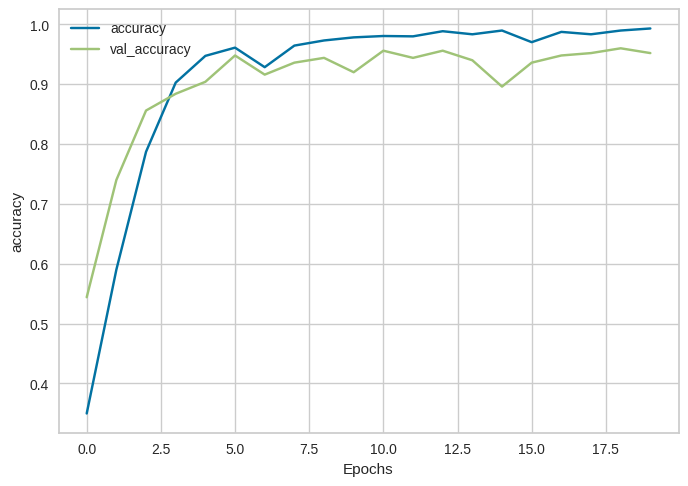

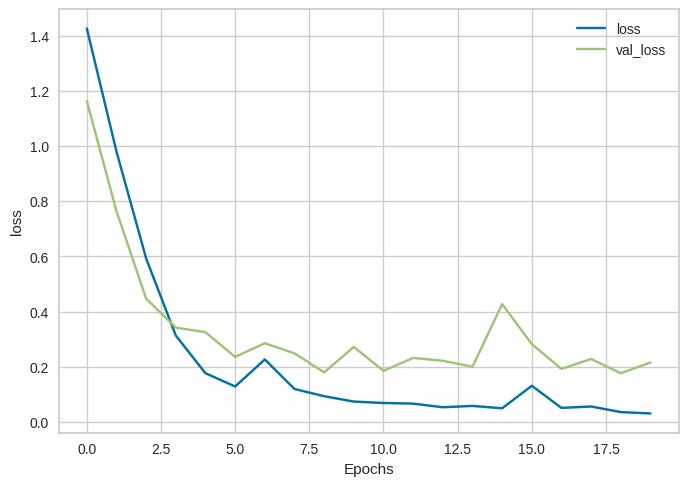

In [ ]:
# Grafik çizim fonksiyonunu tanımlayın

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Eğitim geçmişini görselleştirin
plot_graphs(history, "accuracy")
plot_graphs(history, "loss");


In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])


Validation loss: 0.21599963307380676
Validation accuracy: 0.9520000219345093


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming y_val and y_pred are defined

# If y_val is one-hot encoded, convert it to class labels
if y_val.ndim > 1:
    y_val = np.argmax(y_val, axis=1)

# Predict probabilities on the validation set
y_pred_prob = model.predict(X_val)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Define class labels (adjust according to your specific labels)
target_names = ["BIRADS-1","BIRADS-2","BIRADS-3","BIRADS-4","BIRADS-5"]

# Print classification report
print(classification_report(y_val, y_pred, target_names=target_names))


8/8 [==============================] - 3s 244ms/step
              precision    recall  f1-score   support

    BIRADS-1       1.00      0.50      0.67         6
    BIRADS-2       0.93      0.93      0.93        55
    BIRADS-3       0.94      0.98      0.96        52
    BIRADS-4       0.93      1.00      0.96        63
    BIRADS-5       1.00      0.95      0.97        74

    accuracy                           0.95       250
   macro avg       0.96      0.87      0.90       250
weighted avg       0.95      0.95      0.95       250



In [ ]:
model.save('my_model.h5')
